In [3]:
from proxy_methods_final import *
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import ttest_rel

In [4]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

# Load data
---

In [5]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_44500/1307506813.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


In [6]:
proxy_time_series_final = pd.read_csv('data/proxy_time_series_final.csv')

#Remove row with NSINO Ticker (biggest spread)
proxy_time_series_filtered = proxy_time_series_final[proxy_time_series_final['Ticker'] != 'NSINO']

dates = proxy_time_series_filtered['Date'].unique().tolist()

print(len(dates))

2515


# RMSE Curves
---

In [7]:
rmse_intersection_normal_list, rmse_intersection_communities_list, rmse_csra_normal_list, rmse_csra_communities_list = calculate_rmse_curves(proxy_time_series_filtered, dates)

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])


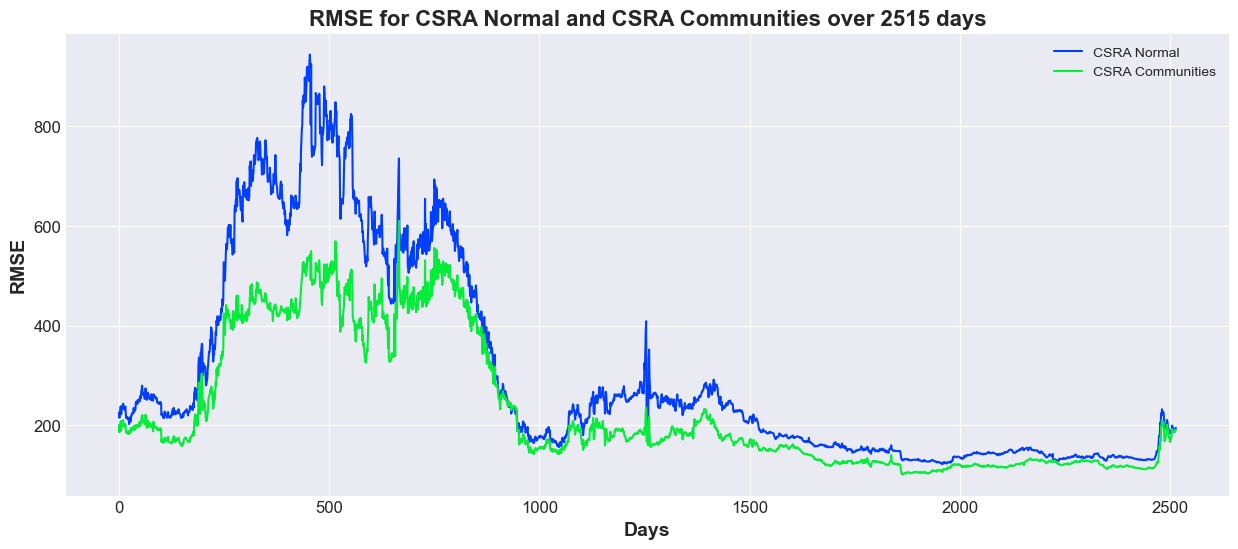

In [8]:
plot_rmse_curves(rmse_csra_normal_list, rmse_csra_communities_list, dates)

In [9]:
calculate_percentage_better(rmse_csra_normal_list, rmse_csra_communities_list, method='CSRA')

Number of days where RMSE for normal CSRA method > RMSE for community CSRA method : 2494
Percentage of days where CSRA Communities method is better: 99.16500994035785%


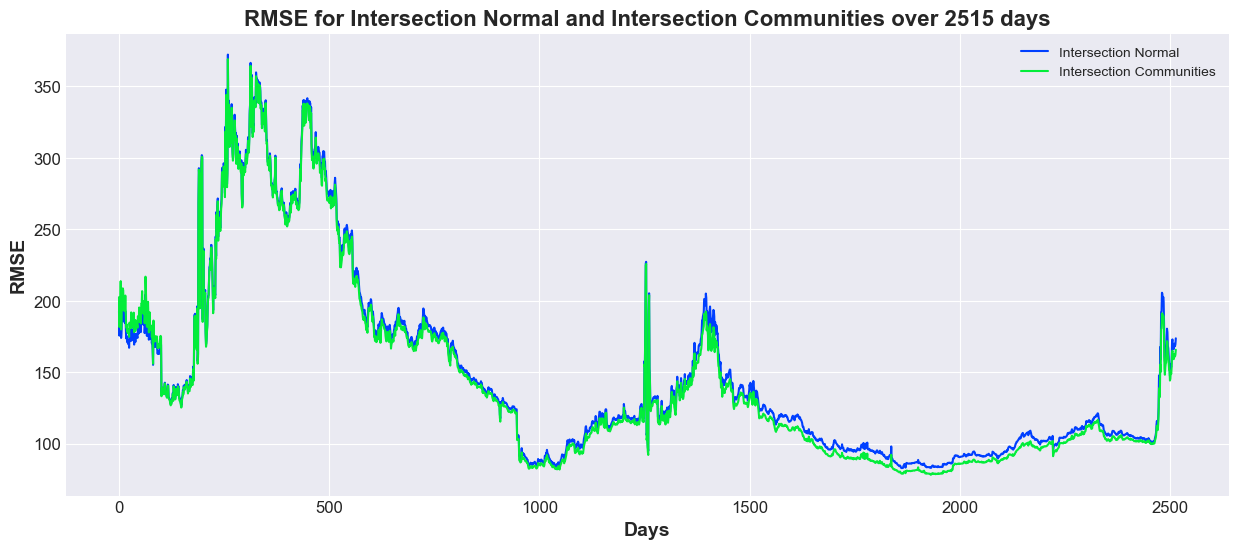

In [13]:
plot_rmse_curves(rmse_intersection_normal_list, rmse_intersection_communities_list,dates, method='Intersection')

In [14]:
calculate_percentage_better(rmse_intersection_normal_list, rmse_intersection_communities_list, method='Intersection')

Number of days where RMSE for normal Intersection method > RMSE for community Intersection method : 2413
Percentage of days where Intersection Communities method is better: 95.94433399602386%


In [15]:
paired_t_test(rmse_csra_normal_list, rmse_csra_communities_list)

Shapiro-Wilk Test Statistic: 0.7323299050331116, p-value: 0.0
CHECKING FOR NORMALITY OF DIFFERENCES
--------------------------------------
The differences do not appear to be normally distributed (reject H0).
Cannot perform a paired t-test.


Text(0.5, 1.0, 'Actual Spread Means')

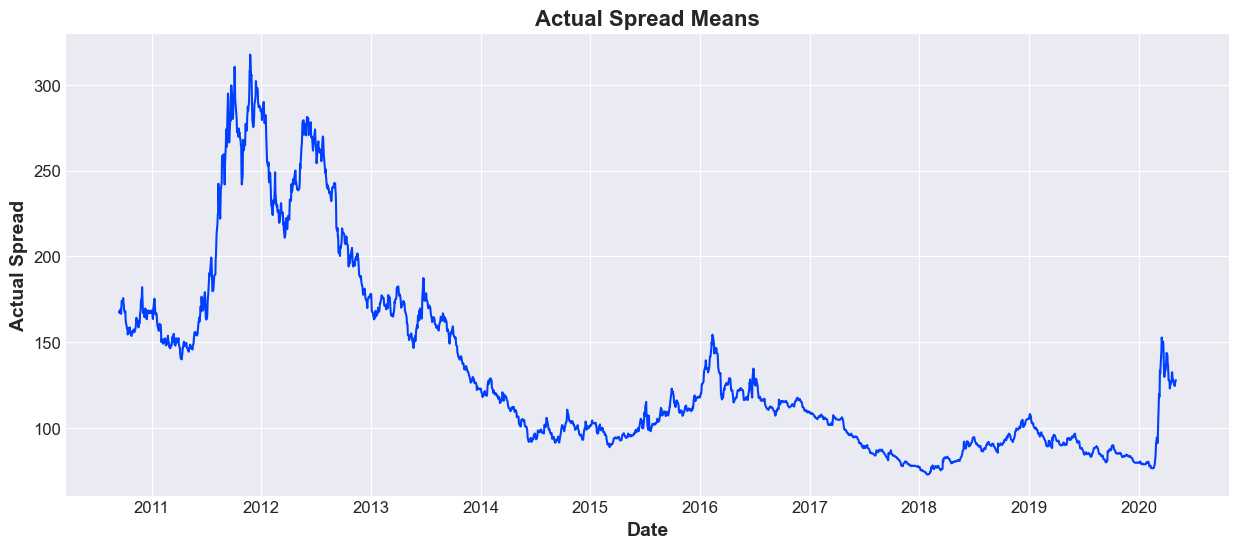

In [17]:
actual_spreads_means = proxy_time_series_filtered['Actual_Spread'].groupby(proxy_time_series_filtered['Date']).mean()
plt.figure(figsize=(15,6))
plt.plot(actual_spreads_means)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Actual Spread', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Actual Spread Means', fontsize=16, fontweight='bold')

# Category Breakdown
---

* ###  Sector

In [13]:
#Sector
rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category = generate_rmse_curves_per_category('Sector',proxy_time_series_filtered,metadata)
average_rmse_per_category_df = create_results_table_for_category('Sector',metadata,rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category)
average_rmse_per_category_df

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Sector,Average_RMSE_Intersection_Normal,Average_RMSE_Intersection_Communities,Average_RMSE_CSRA_Normal,Average_RMSE_CSRA_Communities
0,Basic Materials,173.329225,168.379063,432.111336,252.879356
1,Industrials,152.772415,125.364836,195.657242,136.378311
2,Consumer Services,138.143142,139.106447,235.738083,140.283635
3,Financials,150.567624,151.634694,336.527267,251.608300
4,Utilities,138.025784,137.860375,215.158258,208.511379
5,Consumer Goods,112.108183,108.863239,177.494748,188.333486
6,Technology,178.365614,178.365614,825.722280,294.938249
7,Government,124.625794,124.625794,215.789823,202.830173
8,Health Care,45.143433,45.143433,47.094400,276.943700
9,Oil & Gas,53.304911,56.064692,176.216424,68.917085


* ### Rating

In [14]:
#Rating
rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category = generate_rmse_curves_per_category('AverageRating',proxy_time_series_filtered,metadata)
average_rmse_per_category_df = create_results_table_for_category('AverageRating',metadata,rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category)
average_rmse_per_category_df.sort_values(by='AverageRating')

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,AverageRating,Average_RMSE_Intersection_Normal,Average_RMSE_Intersection_Communities,Average_RMSE_CSRA_Normal,Average_RMSE_CSRA_Communities
11,1,29.906218,29.906218,602.896644,190.842857
12,2,54.882833,54.882833,214.367934,107.614354
8,3,31.534199,31.534199,299.645907,86.829217
13,4,42.088118,42.088118,33.680899,33.416779
3,5,19.723786,19.365828,363.530409,101.464677
7,6,33.295534,37.593227,383.231834,354.507366
4,7,40.363562,42.084767,141.874907,193.766514
9,8,53.993623,53.993623,216.785410,93.878477
1,9,116.349539,109.832281,458.225873,146.682181
2,10,170.527132,165.807815,273.689625,256.758083


* ### Country

In [15]:
#Country
rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category = generate_rmse_curves_per_category('Country',proxy_time_series_filtered,metadata)
average_rmse_per_category_df = create_results_table_for_category('Country',metadata,rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category)
average_rmse_per_category_df

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Country,Average_RMSE_Intersection_Normal,Average_RMSE_Intersection_Communities,Average_RMSE_CSRA_Normal,Average_RMSE_CSRA_Communities
0,United Kingdom,105.509342,106.738026,106.471954,97.664060
1,Spain,81.582567,81.582567,132.014910,124.173880
2,France,125.101988,122.604882,118.644597,131.359923
3,Italy,119.468363,117.618454,143.301672,253.030028
4,Germany,86.183078,89.628678,127.841946,160.138938
5,Netherlands,97.631074,100.812013,709.075537,181.314818
6,Belgium,76.918354,76.918354,419.972881,110.586402
7,Greece,773.336435,773.336435,780.997761,540.198560
8,Luxembourg,230.147408,221.914302,399.503438,255.541381
9,Sweden,177.772432,124.415131,156.745400,166.931360
